In [1]:
from ml_functions import get_historical_data

In [2]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [3]:
import matplotlib.pyplot as plt
import matplotlib
#matplotlib.use('Agg')
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import warnings

#warnings.filterwarnings("ignore")

In [4]:
eth_df = get_historical_data('ETH', 365 )

In [5]:
eth_df.head()

,close
Date,
2019-01-08,150.68
2019-01-09,151.21
2019-01-10,127.96
2019-01-11,126.99
2019-01-12,126.05


In [6]:
transformed_data, lmda = boxcox(eth_df)


In [7]:
lmda

array([-0.55299673])

In [8]:
transformed_data = transformed_data.flatten().tolist()


In [9]:
transformed_df = eth_df.copy()


In [10]:
transformed_df['close'] = transformed_data


In [11]:
transformed_diff_df = transformed_df.diff().dropna()

In [12]:
transformed_diff_df.head()

,close
Date,
2019-01-09,0.000219
2019-01-10,-0.010902
2019-01-11,-0.000521
2019-01-12,-0.000511
2019-01-13,-0.005452


In [13]:
stationary = adfuller(transformed_diff_df['close'])

In [14]:
stationary[1]

0.0

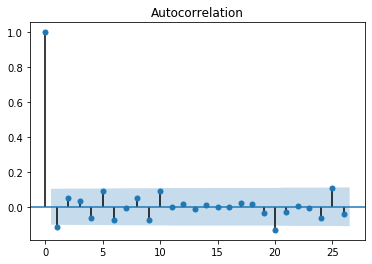

In [18]:
plot_acf(transformed_diff_df)
plt.show()

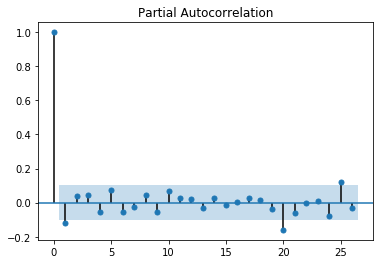

In [19]:
plot_pacf(transformed_diff_df)
plt.show()

seasonal_decompose(transformed_diff_df).plot()
plt.show()

In [145]:
model = SARIMAX(transformed_df, order = ((1,0,0,1),2,1))


In [146]:
model_fit = model.fit(disp = True)


In [147]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             Statespace Model Results                            
=================================================================================
Dep. Variable:                     close   No. Observations:                  366
Model:             SARIMAX((1, 4), 2, 1)   Log Likelihood                1652.795
Date:                   Wed, 08 Jan 2020   AIC                          -3297.591
Time:                           11:33:49   BIC                          -3282.002
Sample:                       01-08-2019   HQIC                         -3291.395
                            - 01-08-2020                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1279      0.068     -1.885      0.059      -0.261       0.005
ar.L4         -0.1911      0.048     -3.970      0.000      -0.286      -0.097
ma.L1         -0.7686      0.052    -14.915      0.000      -0.870      -0.668
sigma2      6.629e-06   2.91e-07     22.754      0.000    6.06e-06     7.2e-06
===================================================================================
Ljung-Box (Q):                       49.93   Jarque-Bera (JB):               226.69
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                            -0.11
Prob(H) (two-sided):                  0.02   Kurtosis:                         6.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

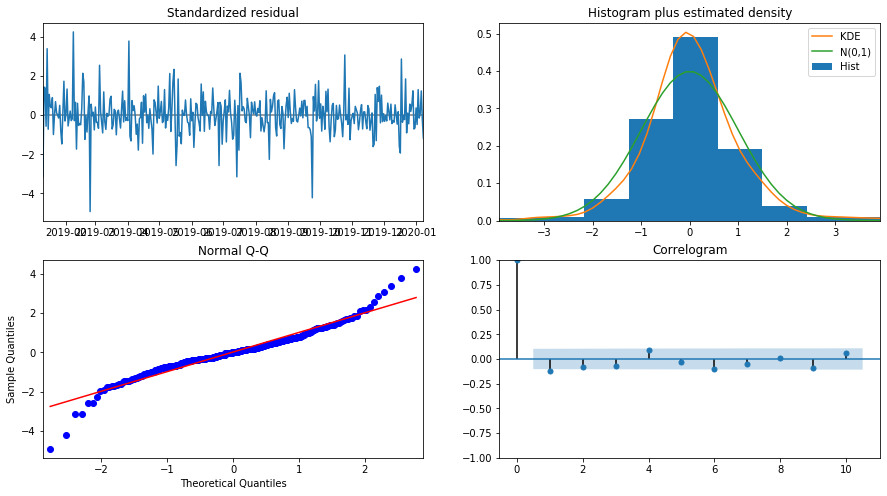

In [148]:
model_fit.plot_diagnostics(figsize=(15,8))
plt.show()


In [160]:
conf_int = model_fit.get_forecast(5)


In [161]:
confidence_intervals = conf_int.conf_int()


In [162]:
confidence_intervals = inv_boxcox(confidence_intervals, lmda)


In [166]:
predictions = model_fit.predict(start= 366, end = 371)


In [167]:
predicted_close = inv_boxcox(predictions, lmda)


In [168]:
predicted_close.head()

2020-01-09    140.137973
2020-01-10    139.303781
2020-01-11    140.618131
2020-01-12    142.199971
2020-01-13    142.759921
Freq: D, dtype: float64

In [174]:
forecast_df = confidence_intervals.copy()


In [175]:
forecast_df['predicted_close'] = predicted_close


In [176]:
forecast_df = final_df.round(2)


In [177]:
forecast_df.head()

,lower close,upper close,predicted_close
2020-01-09,129.88,151.71,140.14
2020-01-10,124.58,156.92,139.30
2020-01-11,121.20,165.33,140.62
2020-01-12,118.02,175.04,142.20
2020-01-13,114.89,182.74,142.76


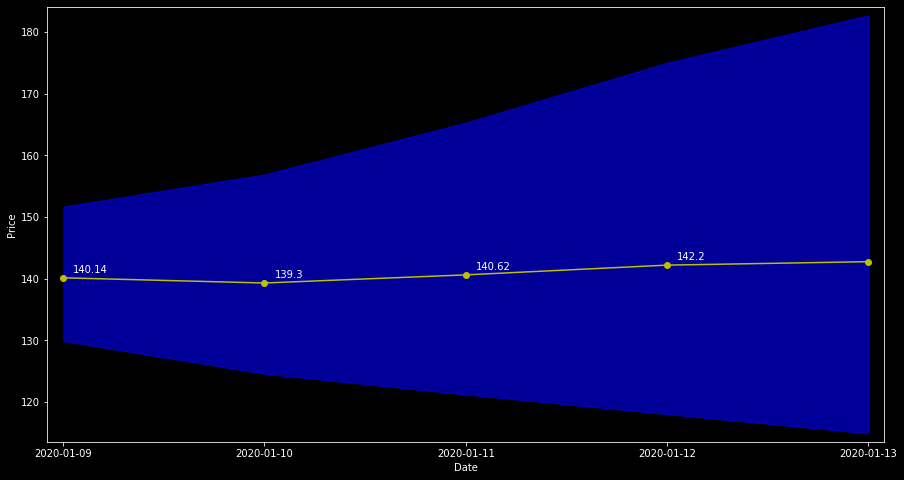

In [178]:
plt.style.use('dark_background')
fig = plt.figure(figsize = (15,8))
plt.plot(forecast_df['predicted_close'], marker = 'o', color = 'y')
plt.fill_between(forecast_df.index, forecast_df['lower close'],forecast_df['upper close'], color = 'b', alpha = 0.6)
plt.ylabel('Price')
plt.xlabel('Date')
plt.margins(0.02)
plt.xticks(forecast_df.index)
for i,j in zip(forecast_df.index[0:4], forecast_df['predicted_close'][0:4]):
    plt.annotate(str(j),xy=(i,j), xytext = (10,5), textcoords= 'offset points')
plt.show()

In [155]:
combined_df = eth_df.copy()

In [156]:
combined_df['predicted_close'] = predicted_close

In [157]:
combined_df = combined_df.round(2).dropna()

In [158]:
combined_df.head()

,close,predicted_close
Date,,
2019-01-10,127.96,151.74
2019-01-11,126.99,119.50
2019-01-12,126.05,119.33
2019-01-13,116.66,119.24
2019-01-14,129.71,114.04


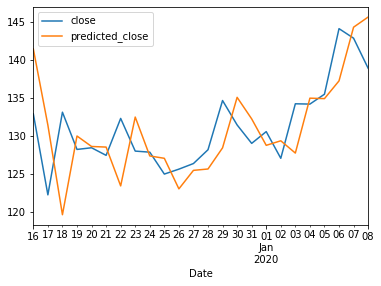

In [159]:
combined_df[340:365].plot()


In [179]:
days_previous_dict = {'BTC': 730, 'ETH': 365}


In [180]:
days_previous_dict['BTC']

730

In [183]:
btc_order = (0,0,0,0,0,0,0,0,1,0,0,0,0,1),1,(1,0,1,1,1)

((0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1), 1, (1, 0, 1, 1, 1))